In [1]:
# 
# We are going to train the healthy VinDr. We have several problems to solve. 
# 
# 1. We have to seperate MLO and CC. ✅
# 2. We have to set them in the same direction. e.g. All right.✅
# 3. We need to resize them.❓
# 4. Need to clean images that are white. ❓
# 5. Some images even though they are cropped appear to have black regions of their previous dimensions. (Perhaps, would be wise to
#    delete them based on their dimensions. However this can be circumsised at the moment.
# )❓
# 
#

In [1]:
import pandas as pd
import numpy as np
import os

import cv2

import shutil
import ast


from PIL import Image
from numpy import asarray 
from skimage.transform import resize

# tqdm doesn't work well in colab.pi
# This is the solution:
# https://stackoverflow.com/questions/41707229/tqdm-printing-to-newline
# import tqdm as tq
#for i in tq.tqdm(...):

#from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
IMAGE_SIZE = 512
base_path = '/home/amargkas/AggelosThesis/data/VinDR/data/source'
os.listdir('/home/amargkas/AggelosThesis/data/VinDR/data/source')

['tempImage.dicom',
 'healthyMLO',
 'LICENSE.txt',
 'finding_annotations.csv',
 'processedMLO',
 'breast-level_annotations.csv',
 'SHA256SUMS.txt']

In [3]:
# Load the prepared train data BI-RADS(1-2)

path = base_path + '/' + 'breast-level_annotations.csv'
df_train_healthy_info = pd.read_csv(path)

print(df_train_healthy_info.shape)

df_train_healthy_info.head()

(20000, 10)


,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split
0,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,L,CC,3518,2800,BI-RADS 2,DENSITY C,training
1,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,L,MLO,3518,2800,BI-RADS 2,DENSITY C,training
2,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,R,CC,3518,2800,BI-RADS 2,DENSITY C,training
3,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,R,MLO,3518,2800,BI-RADS 2,DENSITY C,training
4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,L,CC,3518,2800,BI-RADS 1,DENSITY C,training


In [4]:
# Get all the healthy mammograms that are for training.

df_train = df_train_healthy_info[df_train_healthy_info['split'] == 'training']
df_train

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split
0,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,L,CC,3518,2800,BI-RADS 2,DENSITY C,training
1,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,L,MLO,3518,2800,BI-RADS 2,DENSITY C,training
2,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,R,CC,3518,2800,BI-RADS 2,DENSITY C,training
3,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,R,MLO,3518,2800,BI-RADS 2,DENSITY C,training
4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,L,CC,3518,2800,BI-RADS 1,DENSITY C,training
...,...,...,...,...,...,...,...,...,...,...
19995,f2093a752e6b44df5990f5fd38c99dd2,2b1b2b8f48abab9819c0b3d091e152ee,ea732154d149f619b20070b78060ae65,R,CC,2812,2012,BI-RADS 2,DENSITY C,training
19996,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,4689616c3d0b46fcba7a771107730791,R,CC,3580,2702,BI-RADS 2,DENSITY C,training
19997,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,3c22491bcf1d0b004715c28d80981cdd,L,CC,3580,2702,BI-RADS 2,DENSITY C,training
19998,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,d443b9725e331b8b27589aa725597801,R,MLO,3580,2686,BI-RADS 2,DENSITY C,training


In [5]:
# Get all the healthy mammograms that are for training.

df_test = df_train_healthy_info[df_train_healthy_info['split'] == 'test']
df_test

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split
40,522963c771a84cb777c49ba7a4ca69fc,758269b5ed353cb326e5d450815e8318,04c9b9305ae9a552975cceab2c15632e,L,CC,3518,2800,BI-RADS 1,DENSITY B,test
41,522963c771a84cb777c49ba7a4ca69fc,758269b5ed353cb326e5d450815e8318,a0b73dcf1c300988780abb9abe55826d,L,MLO,3518,2800,BI-RADS 1,DENSITY B,test
42,522963c771a84cb777c49ba7a4ca69fc,758269b5ed353cb326e5d450815e8318,8132013f5158a2bc93d77ea9200c75d8,R,CC,3518,2800,BI-RADS 2,DENSITY B,test
43,522963c771a84cb777c49ba7a4ca69fc,758269b5ed353cb326e5d450815e8318,09c140f91b2da7c7ff024e5f4b2d5599,R,MLO,3518,2800,BI-RADS 2,DENSITY B,test
48,229b0c72152c8c7c6cd902876046c795,ba77420116a36fd24c151e4294114ab3,b045e8b4cbcacce80adb90ee8a9f885a,L,CC,3518,2800,BI-RADS 1,DENSITY C,test
...,...,...,...,...,...,...,...,...,...,...
19931,5e9175554fa9d6b9fb424d7065be4f20,a07d1cc99c7611c815ea99acb324f3b6,4adfc32f03228403f518f24e9b9313cf,R,MLO,3518,2800,BI-RADS 1,DENSITY C,test
19948,bbe97d67cc7f0d28bf9860a864af684a,3dad6ed9f9682dfbb924407f407eaf12,4835a79d7e25eebd20104e7147cbcfb4,L,CC,3518,2800,BI-RADS 2,DENSITY C,test
19949,bbe97d67cc7f0d28bf9860a864af684a,3dad6ed9f9682dfbb924407f407eaf12,ebb437593a3fc80277296638f0607f5b,L,MLO,3518,2800,BI-RADS 2,DENSITY C,test
19950,bbe97d67cc7f0d28bf9860a864af684a,3dad6ed9f9682dfbb924407f407eaf12,9188a01b6b648cee39fb70702a860141,R,CC,3518,2800,BI-RADS 1,DENSITY C,test


In [6]:
# position distribution with split for training
df_train['view_position'].value_counts()

view_position
CC     8001
MLO    7999
Name: count, dtype: int64

In [7]:
# position distribution with split for testing
df_test['view_position'].value_counts()

view_position
CC     2000
MLO    2000
Name: count, dtype: int64

In [8]:
# position distribution without split
df_train_healthy_info['view_position'].value_counts()


view_position
CC     10001
MLO     9999
Name: count, dtype: int64

In [9]:
df_train_MLO =  df_train[df_train['view_position'] == "MLO"]
df_train_CC = df_train[df_train['view_position'] == "CC"]

df_train_MLO.value_counts()

study_id                          series_id                         image_id                          laterality  view_position  height  width  breast_birads  breast_density  split   
0028fb2c7f0b3a5cb9a80cb0e1cdbb91  ff5d6ba6e303628092020e897fcbc9b1  16e58fc1d65fa7587247e6224ee96527  R           MLO            3518    2800   BI-RADS 2      DENSITY C       training    1
acf0e14f8dbde75e46a78e86fe538e24  70aba8f5c1a7f1ef4cbd09a0c566bac4  398056ff018a76ad7379bdd2d5806a07  R           MLO            3518    2800   BI-RADS 1      DENSITY C       training    1
ad3f8280909ad595bf0371958e23d5bd  5ecee5b52da01e425b7371edc3ff847c  927d2afbbe3b82f4ad62acb1f776c87f  R           MLO            3518    2800   BI-RADS 1      DENSITY C       training    1
                                                                    797f89e627f122238f42d22761051981  L           MLO            3518    2800   BI-RADS 1      DENSITY C       training    1
ad3b3c26f89e7b710e633cf310df6051  df4ae4559589b79880e0c8004e

In [ ]:
MLO_DENSITY_4 = df_train_MLO[df_train_MLO['breast_density'] == "DENSITY A"]
MLO_DENSITY_4

In [19]:
MLO_DENSITY_4_and_3 = df_train_MLO[df_train_MLO['breast_density'] != "DENSITY B"]
MLO_DENSITY_4_and_3 = MLO_DENSITY_4_and_3[MLO_DENSITY_4_and_3['breast_density'] != "DENSITY A"]
MLO_DENSITY_4_and_3



,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split
1,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,L,MLO,3518,2800,BI-RADS 2,DENSITY C,training
3,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,R,MLO,3518,2800,BI-RADS 2,DENSITY C,training
5,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,57fbdd278af5c8789a02b355c11620d4,L,MLO,3518,2800,BI-RADS 1,DENSITY C,training
7,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,acccc1727b61b261844d86aa9de53536,R,MLO,3518,2800,BI-RADS 1,DENSITY C,training
9,fa4dcd0f3ba24e86fc8dc25091f7ebd5,a78f4822d806b4f69ba9f0e0c68778b4,48b243704d16570155df12995a284b61,L,MLO,3518,2800,BI-RADS 1,DENSITY C,training
...,...,...,...,...,...,...,...,...,...,...
19991,8db1b8ba11d6d804141f1fa4cf91b614,e26615e35922f3b06ca09a742de0ed8b,bf84bfc8d2bda8d0b2c58b1578e7c694,L,MLO,2812,2012,BI-RADS 2,DENSITY C,training
19992,f2093a752e6b44df5990f5fd38c99dd2,2b1b2b8f48abab9819c0b3d091e152ee,6d33109be809f7813b5e387387072fdb,R,MLO,2812,2012,BI-RADS 2,DENSITY C,training
19993,f2093a752e6b44df5990f5fd38c99dd2,2b1b2b8f48abab9819c0b3d091e152ee,9edcc7df8ac157fb2fdbecb9baae9f2f,L,MLO,2812,2012,BI-RADS 1,DENSITY C,training
19998,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,d443b9725e331b8b27589aa725597801,R,MLO,3580,2686,BI-RADS 2,DENSITY C,training


In [20]:
image_name_list = MLO_DENSITY_4_and_3['image_id'].tolist()
image_name_list

['290c658f4e75a3f83ec78a847414297c',
 '71638b1e853799f227492bfb08a01491',
 '57fbdd278af5c8789a02b355c11620d4',
 'acccc1727b61b261844d86aa9de53536',
 '48b243704d16570155df12995a284b61',
 '633ede597d7e514fe672fbdfc8c269eb',
 '7a3df96890c90370590984ca196d1b40',
 '0a6a90bdc088e0cc62df8d2d58d14840',
 '16724df38e04be5e6ae534eda2185885',
 'da99ea2c75f3021f70607841c0f235b7',
 '0d7b436c03a601820d32511ec3dff8b2',
 '82394d7d4efb3f66fff13da16079cf5b',
 '2ccefd9e7701acf52c92275e844f7578',
 'dedba554dfb143f35b41210d8cfa1537',
 '8338207743a394ab8b56b5b920fc30b6',
 '10c8843264e1faeb12b99e8e83be00ad',
 '529e907813e24ea0c7434c95812f3a44',
 'fb90604f039d294a931b94442e7f8b73',
 '6770e08049264165b58c5f5ddcfd5b95',
 '79929caccef83eaa6f23972d59982913',
 'd0fea1fbbb340fbf5728e16cf4deab35',
 '57aa5a3332bb9bd53d27b223658c9403',
 '81542c5445df43ba480c6bc0563a643e',
 '842b1b1e7e81140a86307bda05757a8a',
 '1057c1e7ece654d4d4262d4feac87ca4',
 '6e9b418a0e8a8b752a97f6f0e998c0d3',
 'af0f6ad067fdf3e94c630ad4f5e5151f',
 

In [27]:
# importing os module  
import os
   
source = "/home/amargkas/AggelosThesis/data/VinDR/data/source/processedMLO/healthyMLOwithReversedImages"
dest = "/home/amargkas/AggelosThesis/data/VinDR/data/source/processedMLO/teamCandDMLO"
# Loop over images in directory
os.chdir(dest)

In [29]:

for cnt, filename in enumerate(os.listdir(source)):
    
    name = os.path.splitext(filename)[0]
    # Load image
    image_path = os.path.join(source, filename)
    image = cv2.imread(image_path)

    if name in image_name_list:
        cv2.imwrite(filename, image)

In [30]:
print(len(os.listdir(dest)))

5008


In [29]:
## DICOM TO PNG Converter

import cv2
import os
import pydicom

inputdir = '/home/amargkas/AggelosThesis/data/VinDR/data/source/images/0a0c5108270e814818c1ad002482ce74/'
outdir = './'
f = "tempImage.dicom"
#os.mkdir(outdir)

#test_list = [ f for f in  os.listdir(inputdir)]

#for f in test_list[:10]:   # remove "[:10]" to convert all images 
ds = pydicom.read_file("/home/amargkas/AggelosThesis/data/VinDR/data/source/" + f) #pydicom.read_file(inputdir + f) # read dicom image
img = ds.pixel_array # get image array

cv2.imwrite(outdir + f.replace('.dicom','.png'),img) # write png image

True

In [ ]:
# ---- We have 10.000 MLO's from VinDR ---------
# Goal => 512x512 cropped and informatius. 
# Then filter the MIAS dataset to see the healthy ones from there and add them.
#
# I believe is better not to add the CBIS dataset for the first training of the CycleGAN2.

# TODO: 1. Need to get all the MLO's from Dicom format and convert the to png.
#       2. After they are saved use the filter below to reverse the ones that have a problem with intensity.
#       3. The turn them all to left side.
#       4. Then push the crop of the NYU.
#       5. Finally resize them at 512x512.


# Future TODO: Study how to dockerize the dataset so to have it on an easier use on the future.

from NYU_crop_single_mammogram import crop_mammogram_one_image
from organizedProcessing import import_and_plot_histogramm, crop_a_normal_mammogramm

# vector arranging the transformation of the image, needed on the NYY library.
scan = {"horizontal_flip": "NO", "side": "R"}

INPUT = "/home/amargkas/AggelosThesis/data/VinDR/data/source/images/0a0c5108270e814818c1ad002482ce74/0a6a90bdc088e0cc62df8d2d58d14840.dicom"

crop_a_normal_mammogramm(INPUT)



In [17]:
# Get the path to each image
base_path_healhy_tainings = "/home/amargkas/VinDR/physionet.org/training_healthy/cropped_healthy_mammograms/"

def get_path(row):
    
    study_id = row['study_id']
    image_id = row['image_id']
    path = base_path_healhy_tainings + image_id + '.png'
    
    return path


df_train_MLO['path'] = df_train_MLO.apply(get_path, axis=1)
df_train_CC['path'] = df_train_CC.apply(get_path, axis=1)

print(df_train_MLO.shape)
print(df_train_CC.shape)

#df_train_MLO.head()
df_train_CC.head()

(9999, 11)
(10001, 11)


,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split,path
0,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,L,CC,3518,2800,BI-RADS 2,DENSITY C,training,/home/amargkas/VinDR/physionet.org/training_he...
2,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,R,CC,3518,2800,BI-RADS 2,DENSITY C,training,/home/amargkas/VinDR/physionet.org/training_he...
4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,L,CC,3518,2800,BI-RADS 1,DENSITY C,training,/home/amargkas/VinDR/physionet.org/training_he...
6,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,202d761a6b0f86faaeefc39ee18b1c53,R,CC,3518,2800,BI-RADS 1,DENSITY C,training,/home/amargkas/VinDR/physionet.org/training_he...
8,fa4dcd0f3ba24e86fc8dc25091f7ebd5,a78f4822d806b4f69ba9f0e0c68778b4,a3d0e2394d7db36afab1b6e5e24da798,L,CC,3518,2800,BI-RADS 1,DENSITY C,training,/home/amargkas/VinDR/physionet.org/training_he...


In [18]:
input_dir = df_train_MLO['path'].tolist()
len(input_dir)

input_laterality = df_train_MLO['laterality'].tolist()
len(input_laterality)

input_image_id = df_train_MLO['image_id'].tolist()
len(input_image_id)



9999

In [2]:
# input_dir = df_train_CC['path'].tolist()
# len(input_dir)

# input_laterality = df_train_CC['laterality'].tolist()
# len(input_laterality)

# input_image_id = df_train_CC['image_id'].tolist()
# len(input_image_id)


In [3]:
# Python program to explain cv2.imwrite() method
  
# importing cv2 
import cv2
  
# importing os module  
import os
  
# Image directory
directory = r'/home/amargkas/VinDR/physionet.org/healthyMLOwithReversedImages'
   
# Change the current directory 
# to specified directory 
os.chdir(directory)
  

In [ ]:

from matplotlib import pyplot as plt
import numpy as np
import cv2  # importing cv
import imutils

goal_dir = "/home/amargkas/VinDR/physionet.org/healthyMLO/"
images_with_low_intensities = []
images_with_high_intensities = []
new_filtered_images = []

sample_dir = input_dir[0:5]

for count, value in enumerate(input_dir):

    print( "Laterality: " + input_laterality[count])
    image = cv2.imread(value)
    intensity = np.mean(image)
    #print(intensity)

    image_filename = str(input_image_id[count]) + ".png"
    print(image_filename)

    
    # if intensity >= 160:

    #     print("Image with Intensity > 160.")
    #     # plt.imshow(image)
    #     # plt.show()
    #     #images_with_high_intensities.append(image)
    #     continue

    # elif intensity < 50:
    #     continue
        #plt.imshow(image)
        #plt.show()
        # path = goal_dir + "/" + os.path.basename(value)
        # print("Image with Intensity > 50.")
        # images_with_low_intensities.append(image)
        

    if (intensity < 167 and intensity > 53):#and os.path.isfile(image_filename) == False

        if input_laterality[count] == "R":

            image = cv2.transpose(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE))

            # Using cv2.imwrite() method
            # Saving the image
            cv2.imwrite(image_filename, image)
            
            # List files and directories  
            # in 'C:/Users / Rajnish / Desktop / GeeksforGeeks'  
            print("After saving image:")  
            print(os.listdir(directory))
            
            print('Successfully saved')


        else:


            #plt.imshow(image)
            #plt.show()
            path = goal_dir + "/" + os.path.basename(value)
            #print(path)

            # Using cv2.imwrite() method
            # Saving the image
            cv2.imwrite(image_filename, image)
            
            # List files and directories  
            # in 'C:/Users / Rajnish / Desktop / GeeksforGeeks'  
            print("After saving image:")  
            print(os.listdir(directory))
            
            print('Successfully saved')


    elif (intensity > 167): # (intensity > 156 and os.path.isfile(image_filename) == False)


        if input_laterality[count] == "R":

            reversed_image = 255 - image
            image = cv2.transpose(cv2.rotate(reversed_image, cv2.ROTATE_90_COUNTERCLOCKWISE))

            # Using cv2.imwrite() method
            # Saving the image
            cv2.imwrite(image_filename, image)
        
            # List files and directories  
            # in 'C:/Users / Rajnish / Desktop / GeeksforGeeks'  
            print("After saving image:")  
            print(os.listdir(directory))
        
            print('Successfully saved')


        else:


            #plt.imshow(image)
            #plt.show()
            path = goal_dir + "/" + os.path.basename(value)
            #print(path)
            reversed_image = 255 - image
            # Using cv2.imwrite() method
            # Saving the image
            cv2.imwrite(image_filename, reversed_image)
        
            # List files and directories  
            # in 'C:/Users / Rajnish / Desktop / GeeksforGeeks'  
            print("After saving image:")  
            print(os.listdir(directory))
        
            print('Successfully saved')


SyntaxError: invalid syntax (2539326544.py, line 79)

In [2]:
import os
import shutil

source_folder = '/home/amargkas/VinDR/physionet.org/train100kPatches/source'
destination_folder = '/home/amargkas/VinDR/physionet.org/smallPatchesDataset/source'

# for file_name in os.listdir(destination_folder)[1:100]:
#     source_file = os.path.join(destination_folder, file_name)
#     print(source_file)
#     os.remove(source_file)

for file_name in os.listdir(source_folder)[0:200]:
    source_file = os.path.join(source_folder, file_name)
    if os.path.isfile(source_file):
        destination_file = os.path.join(destination_folder, file_name)
        shutil.move(source_file, destination_file)

In [16]:
for image in images_with_low_intensities:
    plt.imshow(image)
    plt.show()

0
107.73814702182602


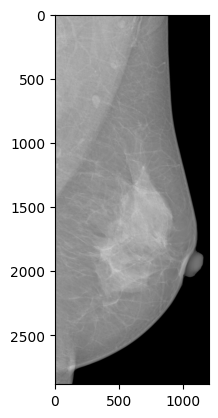

In [ ]:
%matplotlib inline
#The line above is necesary t o show Matplotlib's plots inside a Jupyter Notebook

#
#  TODO: Manage problematic images. White ones I tried to do it based on the dimension but it seems to be many images
#        with width more than 2800. (Didn't work). 🌀
#   TODO (NEW) : create a file with all the MLO being left and no whites.
#                1. Get all images with their path.capitalize
#                2. Rotate the right ones.
#                3. Filter the white ones . EXTRA: Maybe we can work on that information so we don't lose these images.
#                4. Save them in a file.
#


from matplotlib import pyplot as plt
import numpy as np
import cv2  # importing cv
import imutils

df_train_MLO_R_possible_bad_images = df_train_MLO_R[df_train_MLO_R['width'] >= 3000]

print(len(df_train_MLO_R_possible_bad_images))
# read an image as input using OpenCV
image = cv2.imread(input_dir[3201]) # 3200 einai aspri

print(np.mean(image))

# Rotate Right images to left.
Rotated_image = cv2.transpose(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE))


#Show the image with matplotlib
plt.imshow(Rotated_image)
plt.show()


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import cv2  # importing cv
import imutils

images_with_big_intensities = []
intensities = []
print(len(df_train_MLO_R))

# read an image as input using OpenCV
image = cv2.imread(input_dir[3200]) # 3200 einai aspri

print(np.mean(image))

for i in range(len(input_dir)):
    
    img = cv2.imread(input_dir[i]) # 3200 einai aspri
    mean = np.mean(img)
    intensities.append(mean)

    if mean > 150:

        images_with_big_intensities.append(img)


plt.hist(intensities, bins = [0,50,100,150,200,250]) 
plt.title("Intensities Distribution") 
plt.show()

4000
111.72970639348537


KeyboardInterrupt: 

In [ ]:
count160 = len([i for i in intensities if i < 160])
print(count160)

count170 = len([i for i in intensities if i < 170 and i > 160])
print(count170)

count180 = len([i for i in intensities if i < 180 and i > 170])
print(count180)

count190 = len([i for i in intensities if i < 190 and i > 180])
print(count190)


6446
64
91
175


In [ ]:
images_of_interest = []

for image in images_with_big_intensities:
    mean = np.mean(image)
    if mean > 160 and mean < 170:
        images_of_interest.append(image)

print(len(images_of_interest))

64


In [ ]:
# Σε αυτά τα intensities έχουμε άσπρες εικόνες. Να κοιτάξω μήπως μπορώ να κάνω κάποιο transformation ώστε να μην τις πετάξω 
# Επίσης να ψάξω να δω και τι πληροφορία έχουν οι εικόνες μετα χαμηλά intensities από τον παραπάνω γράφο. 
# Το γράφημα υπάρχει και στο τσατ στο facebook.

for cnt in range(10,30):

        plt.imshow(images_of_interest[cnt])
        plt.show( )

NameError: name 'plt' is not defined

In [3]:
import os

path = "/home/amargkas/VinDR/physionet.org/TrainPatchesMLO/source"
files = os.listdir(path)
num_files = len(files)

num_files

1000000